In [1]:
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 20
RAM GB: 31.2
PyTorch version: 1.11.0
CUDA version: 11.3
cuDNN version: 8200
device: cuda
Mon May  9 21:19:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8    30W / 420W |    269MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+---------------

In [2]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
if info.total>16252636672:
  print('Everything is ok, you can begin')
else:
  print('We dont recomend to begin, you gonna get Out of memory')

Everything is ok, you can begin


In [3]:
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_ruclip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything
device = 'cuda'
model = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
vae = get_vae().to(device)
tokenizer = get_tokenizer()

Downloading:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready


In [4]:
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF


class RuDalleDataset(Dataset):
    clip_filter_thr = 0.24
    def __init__(
            self,
            file_path,
            csv_path,
            tokenizer,
            resize_ratio=0.75,
            shuffle=True,
            load_first=None,
            caption_score_thr=0.6
    ):
        """ tokenizer - объект с методами tokenizer_wrapper.BaseTokenizerWrapper """
       
        self.text_seq_length = model.get_param('text_seq_length')
        self.tokenizer = tokenizer
        self.target_image_size = 256
        self.image_size=256
        self.samples = []


        self.image_transform = T.Compose([
                T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
                T.RandomResizedCrop(self.image_size,
                                    scale=(1., 1.), # в train было scale=(0.75., 1.),
                                    ratio=(1., 1.)),
                T.ToTensor()
            ])
        
        df = pd.read_csv(csv_path)
        for caption, f_path  in zip(df['caption'], df['name']):
            if len(caption)>10 and len(caption)<100 and os.path.isfile(f'{file_path}/{f_path}'):

              self.samples.append([file_path, f_path, caption])
        if shuffle:
            np.random.shuffle(self.samples)
            print('Shuffled')
    
    def __len__(self):
        return len(self.samples)

    def load_image(self, file_path, img_name):
        image = PIL.Image.open(f'{file_path}/{img_name}')
        return image

    def __getitem__(self, item):
        item = item % len(self.samples)  # infinite loop, modulo dataset size
        file_path, img_name, text = self.samples[item]
        try:
          image = self.load_image(file_path, img_name)
          image = self.image_transform(image).to(device)
        except Exception as err:  # noqa
            print(err)
            random_item = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(random_item)
        text =  tokenizer.encode_text(text, text_seq_length=self.text_seq_length).squeeze(0).to(device)
        return text, image

In [5]:
class Args():
    def __init__(self):
     
        self.text_seq_length = model.get_param('text_seq_length')
        self.total_seq_length = model.get_param('total_seq_length')
        self.epochs = 1
        self.save_path='checkpoints/'
        self.model_name = 'awesomemodel_'
        self.save_every = 2000
        self.prefix_length = 10
        self.bs = 1
        self.clip = 0.24
        self.lr = 4e-5
        self.warmup_steps =50
        self.wandb = True
args = Args()
if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)

In [6]:
!gdown https://drive.google.com/uc?id=1p4xwKEDHPhm18zBS_pMVJ1mp2Y5CE1a8
!gdown https://drive.google.com/uc?id=1iSDbibP-o9gIk9YzpmI-Y_h_uWPqxTZh
!unzip sneaksa.zip

Downloading...
From: https://drive.google.com/uc?id=1p4xwKEDHPhm18zBS_pMVJ1mp2Y5CE1a8
To: /home/gensyn/repos/ru-dalle/jupyters/sneaksa.zip
100%|██████████████████████████████████████| 81.7M/81.7M [00:08<00:00, 10.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iSDbibP-o9gIk9YzpmI-Y_h_uWPqxTZh
To: /home/gensyn/repos/ru-dalle/jupyters/data_desc.csv
100%|████████████████████████████████████████| 728k/728k [00:00<00:00, 3.37MB/s]
Archive:  sneaksa.zip
replace content/sneaks/Image_3984.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
from torch.utils.data import Dataset, DataLoader
st = RuDalleDataset(file_path='./content/sneaks/' ,csv_path ='data_desc.csv',tokenizer=tokenizer)
train_dataloader = DataLoader(st, batch_size=args.bs, shuffle=True, drop_last=True)

In [8]:
st.samples

[['./content/sneaks/', 'Image_3287.jpg', 'Кроссовки, Tosca Blu, цвет: черный'],
 ['./content/sneaks/', 'Image_1165.jpg', 'Кроссовки, Demix, цвет: фиолетовый'],
 ['./content/sneaks/', 'Image_2778.jpg', 'Кроссовки, TimeJump, цвет: белый'],
 ['./content/sneaks/', 'Image_6137.jpg', 'Кроссовки, Sprincway, цвет: белый'],
 ['./content/sneaks/', 'Image_645.jpg', 'Кроссовки, Nike, цвет: черный'],
 ['./content/sneaks/', 'Image_4807.jpg', 'Кроссовки, Tervolina, цвет: серый'],
 ['./content/sneaks/', 'Image_429.jpg', 'Кроссовки, Salomon, цвет: розовый'],
 ['./content/sneaks/', 'Image_2477.jpg', 'Кроссовки, PUMA, цвет: черный'],
 ['./content/sneaks/', 'Image_2202.jpg', 'Кроссовки, Caprice, цвет: хаки'],
 ['./content/sneaks/',
  'Image_7983.jpg',
  'Кроссовки, Philippe Model Paris, цвет: бирюзовый'],
 ['./content/sneaks/', 'Image_159.jpg', 'Кроссовки, Merrell, цвет: черный'],
 ['./content/sneaks/', 'Image_8980.jpg', 'Кроссовки, Nike, цвет: зеленый'],
 ['./content/sneaks/', 'Image_3973.jpg', 'Кроссовк

In [9]:
#Setup logs
#import os
#os.environ["WANDB_START_METHOD"] = "thread"
try:
  import wandb
  wandb.init(project = args.model_name, entity = "fastflair")#change it
  args.wandb = True
except:
  args.wandb = False

wandb: Currently logged in as: fastflair. Use `wandb login --relogin` to force relogin
2022-05-09 21:29:44.640802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 21:29:44.640816: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
from transformers import  AdamW, get_linear_schedule_with_warmup
model.train()
optimizer = AdamW(model.parameters(), lr = args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, 
                                                final_div_factor=500,  
                                                steps_per_epoch=len(train_dataloader), epochs=args.epochs )

In [11]:
def freeze(
    model,
    freeze_emb=True,
    freeze_ln=False,
    freeze_attn=False,
    freeze_ff=True,
    freeze_other=True,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [12]:
#markdown Simple training loop
def train(model,args: Args, train_dataloader: RuDalleDataset):
  
  
  """
  args - arguments for training

  train_dataloader - RuDalleDataset class with text - image pair in batch
  """
  loss_logs = []
  try:
    progress = tqdm(total=len(train_dataloader), desc='finetuning goes brrr')
    save_counter = 0
    for epoch in range(args.epochs):
      
      for text, images in train_dataloader:
        device = model.get_param('device')
        save_counter+=1
        model.zero_grad()
        attention_mask = torch.tril(torch.ones((args.bs, 1, args.total_seq_length, args.total_seq_length), device=device))
        image_input_ids = vae.get_codebook_indices(images)
        
        input_ids = torch.cat((text, image_input_ids), dim=1) 
        loss, loss_values = model.forward(input_ids, attention_mask, return_loss=True)
        #train step
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        #save every here
        if save_counter % args.save_every == 0:
          print(f'Saveing checkpoint here {args.model_name}_dalle_{save_counter}.pt')
          
          plt.plot(loss_logs)
          plt.show()
          torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}_dalle_{save_counter}.pt")
                    )
        if args.wandb:
          wandb.log({"loss":  loss.item()})
        loss_logs+=[loss.item()]
        progress.update()
        progress.set_postfix({"loss": loss.item()})
    
    print(f'Complitly tuned and saved here  {args.model_name}__dalle_last.pt')
    
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_dalle_last.pt")
                )
  
  except KeyboardInterrupt:
    
    
    print(f'What for did you stopped? Please change model_path to /{args.save_path}/{args.model_name}_dalle_Failed_train.pt')
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_dalle_Failed_train.pt")
                )
  except Exception as err:
    print(f'Failed with {err}')

finetuning goes brrr:   0%|                            | 0/9406 [00:00<?, ?it/s]/home/gensyn/repos/ru-dalle/rudalle/dalle/model.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row_ids = torch.arange(past_length, input_shape[-1] + past_length,
finetuning goes brrr:  21%|█▍     | 1999/9406 [10:15<37:47,  3.27it/s, loss=2.8]

Saveing checkpoint here awesomemodel__dalle_2000.pt


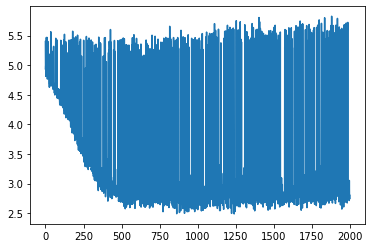

finetuning goes brrr:  43%|██▌   | 3999/9406 [20:32<27:34,  3.27it/s, loss=5.59]

Saveing checkpoint here awesomemodel__dalle_4000.pt


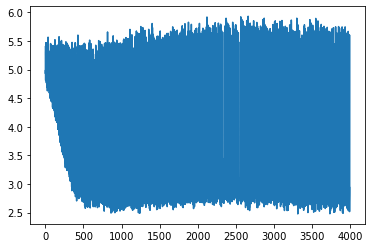

finetuning goes brrr:  44%|██▋   | 4136/9406 [21:18<27:36,  3.18it/s, loss=3.34]

In [ ]:
#@markdown You can unfreeze or freeze more parametrs, but it can 
model = freeze(model = model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False)#freeze params to 

train(model, args, train_dataloader)

In [ ]:
#load model 
model_path = os.path.join('/content/'+args.save_path,f"{args.model_name}_dalle_last.pt")
model = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
model.load_state_dict(torch.load(model_path)) 
print(f'Loaded from {model_path}')
vae = get_vae().to(device)

In [ ]:
pil_images = []
scores = []
text = 'Кроссовки, Nike, цвет: черный'

for top_k, top_p, images_num in [(2048, 0.995, 3)]:
    _pil_images, _scores = generate_images(text, tokenizer, model, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
show([pil_image for pil_image in pil_images], 3)

In [ ]:
pil_images = []
scores = []
text = 'Кроссовки, Adidas superstar, цвет: белый'

for top_k, top_p, images_num in [(2048, 0.995, 10)]:
    _pil_images, _scores = generate_images(text, tokenizer, model, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
show([pil_image for pil_image in pil_images], 10)

In [ ]:
pil_images[1]